In [7]:
import os
import pycolmap
from pathlib import Path
import numpy as np
import cv2
from collections import defaultdict
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt
from hloc.utils.read_write_model import rotmat2qvec, qvec2rotmat
import seaborn as sns
from hloc.utils.io import list_h5_names, get_matches, get_keypoints
from hloc.visualization import plot_images, plot_keypoints, plot_matches, read_image, add_text, cm_RdGn
from hloc import localize_inloc,reconstruction

In [8]:

def get_camera_poses(reconstruction) -> np.ndarray:
    """Extracts camera positions from reconstruction.

    Args:
        reconstruction: pycolmap.Reconstruction(/path)

    Returns:
        np.ndarray: of shape (N, 3)
    """
    cameras = reconstruction.cameras
    images = reconstruction.images

    N = len(images)
    camera_poses = np.zeros((N, 3))
    for i, k1 in enumerate(images.keys()):
        image_1 = images[k1]
        camera_1 = cameras[image_1.camera_id]
        camera_poses[i] = backward_project(
            points_2d=np.array([[0, 0]]),
            image=image_1,
            camera=camera_1,
            depth=0,
        )
    return camera_poses

def backward_project(
    points_2d: np.ndarray, image: pycolmap.Image, camera: pycolmap.Camera, depth: np.ndarray
) -> np.ndarray:
    """Project array of 2D points into the 3D world space given a depth map.

    Args:
        points2d (np.ndarray): Array of 2D points with shape (n, 2).
        image (pycolmap.Image): Image from which the points are taken.
        camera (pycolmap.Camera): Camera associated with the image.
        depth (np.ndarray): Associated depth map with shape (n,).

    Returns:
        np.ndarray: Array of backward projected 3D points from the given 2D points.
    """
    p_world = np.array(camera.image_to_world(points_2d))
    p_world = np.stack([p_world[:, 0], p_world[:, 1], np.ones_like(p_world[:, 0])]) * depth
    p_world = np.array(image.transform_to_world(p_world.T))

    return p_world

def create_all_figures(
    sparse_model_path,
    output_path=None,
    depth_path = None,
) -> None:
    """Loads a reconstrucion and stores all necessary plots.

    Args:
        sparse_model_path (str): Path to the sparse model
        output_path (str): Path to the output folder
        depth_path (Optional[str], optional): Path to the depth maps. Defaults to None.
    """
    try:
        reconstruction = pycolmap.Reconstruction(sparse_model_path)
        camera_poses = get_camera_poses(reconstruction)
        points = np.array([p.xyz for p in reconstruction.points3D.values()])
        align = pca(camera_poses)
        # alternative to pca
        # align = lambda x: x @ np.array([[0, -1, 0], [0, 0, -1], [1, 0, 0]])
        out_file=None
        create_view_projection_figure(
            [align(points), align(camera_poses)], path=out_file
        )

        # sparse overlap matrix
        sparse_overlap_matrix = overlap.sparse_overlap(reconstruction)
        view_overlap.show_matrix(
            sparse_overlap_matrix, os.path.join(output_path, "sparse_overlap_matrix.jpg")
        )
        view_overlap.vis_overlap(
            sparse_overlap_matrix,
            align(camera_poses),
            align(points),
            os.path.join(output_path, "vis_sparse_overlap.jpg"),
        )

        if depth_path is not None:
            dense_overlap_matrix = overlap.dense_overlap(reconstruction, depth_path=depth_path)
            view_overlap.show_matrix(
                dense_overlap_matrix,
                os.path.join(
                    output_path,
                    "dense_overlap_matrix.jpg",
                ),
            )
            view_overlap.vis_overlap(
                dense_overlap_matrix,
                align(camera_poses),
                align(points),
                os.path.join(output_path, "vis_dense_overlap.jpg"),
            )
    except Exception as e:
        print(e)

def pca(data):
    """Computes pca on the data matrix and returns a coordinate transform as a lambda function.

    Args:
        data: np.ndarray of shape (N, 3)

    Returns:
        lambda x: np.ndarray of shape (N, 3) -> np.ndarray of shape (N, 3)

    """
    mean = data.mean(axis=0)
    standardized_data = data - mean
    scale = data.std()
    standardized_data /= scale
    covariance_matrix = np.cov(standardized_data, ddof=0, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    order_of_importance = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, order_of_importance]
    # Ensure handedness doesnt change
    if np.linalg.det(sorted_eigenvectors) < 0:
        sign = np.sign(np.ones((1, 3)) @ sorted_eigenvectors)
        det_sign = np.linalg.det(sorted_eigenvectors)
        sorted_eigenvectors = sorted_eigenvectors * sign * det_sign

    return (
        lambda x: (x - mean)
        / scale
        @ sorted_eigenvectors
        # @ np.array([[0, -1, 0], [0, 0, -1], [1, 0, 0]]).T  # inverse
    )



def plot_view_projection(
    Data: np.ndarray, view: int, limit: int = 2, s: float = 1, alpha: float = 0.1, *args, **kwargs
) -> None:
    """Creates an axis aligned plot.

    Args:
        Data (np.ndarray): List of np.ndarrays of shape (N, 3) [np.ndarray, ..]
        view (int): Int to select from ["Top View", "Front View", "Right View"]
        limit (int, optional): Limits of the plot limit=3 should contain 99% of the camera
        positions. Defaults to 10.
        s (float, optional): Size for dots. Defaults to 1.
        alpha (float, optional): Set transparency for dots. Defaults to 0.1.
    """
    view_names = ["Top View", "Front View", "Right View"]
    id1, id2 = [(0, 1), (0, 2), (1, 2)][view]
    for data in Data:
        labels = ["X", "Z", "Y"]
        plt.scatter(data[:, id1], data[:, id2], s=s, alpha=alpha, *args, **kwargs)
        plt.title(view_names[view])
    plt.axis("scaled")
    plt.xlim(-limit, limit)
    plt.ylim(-limit, limit)
    plt.axis("off")
    plt.xlabel(labels[id1], labelpad=0)
    plt.ylabel(labels[id2], labelpad=0)


def create_view_projection_figure(
    data: np.ndarray,
    view = None,
    path = None,
    *args,
    **kwargs,
) -> None:
    """Creates an axis aligned plot.

    Args:
        data (np.ndarray): List of np.ndarrays of shape (N, 3) [np.ndarray, ..]
        view (Optional[int], optional): Int to select from ["Top View", "Front View", "Right View"]
        path (Optional[str], optional): Filepath to store the plot. Defaults to None.
    """
    fig = plt.figure(figsize=(15, 15))
    plt.tight_layout()
    if view is None:
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plot_view_projection(data, i, *args, **kwargs)
    else:
        plot_view_projection(data, view, *args, **kwargs)
    if path is None:
        plt.show()
    else:
        fig.savefig(path, dpi=900, bbox_inches="tight")
    plt.close(fig)


In [9]:
scene_dir = Path(f"../outputs/ALIKED2K+DISK+SIFT-rot-sci/heritage/dioscuri")


Found 1 models


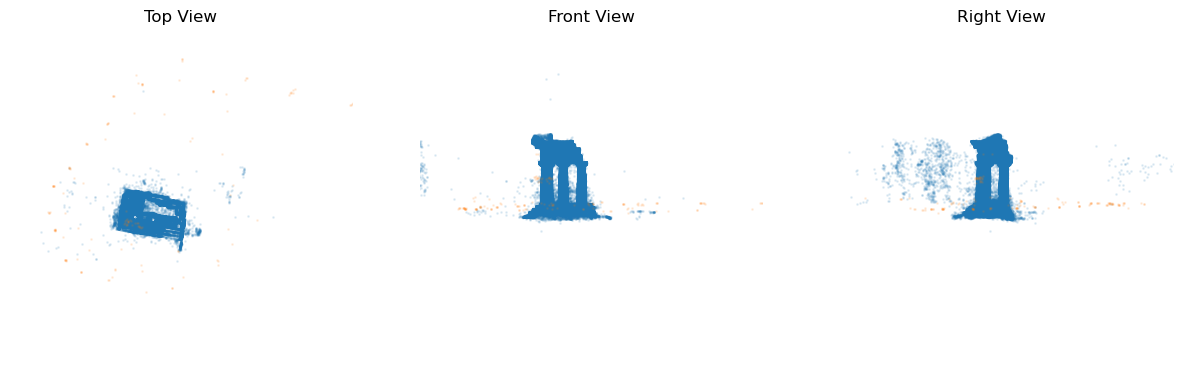

name 'overlap' is not defined
165 0


Found 1 models


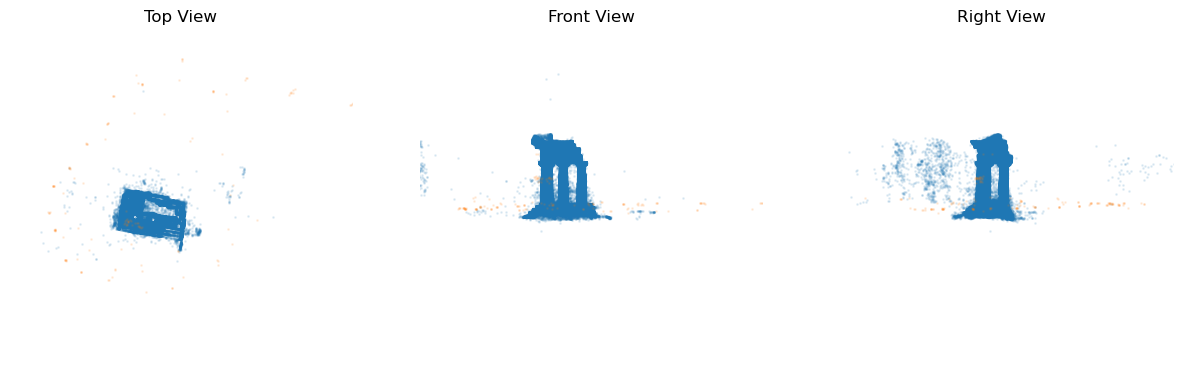

name 'overlap' is not defined


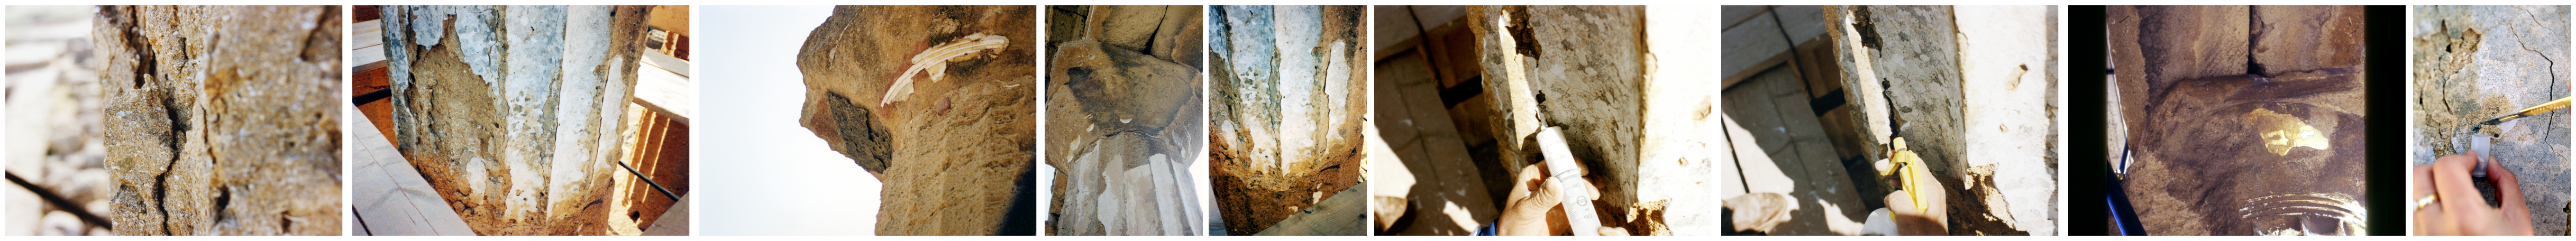

{'archive_0023.png': (array([[-0.97023366,  0.24184346,  0.01258488],
         [ 0.22714142,  0.92681286, -0.29903961],
         [-0.0839846 , -0.28727975, -0.95415771]]),
  array([0.41257219, 1.03517437, 2.01495546])),
 'archive_0036.png': (array([[-0.98612366,  0.10368667,  0.12965033],
         [ 0.10932914,  0.99331042,  0.03716921],
         [-0.12492908,  0.05082799, -0.99086288]]),
  array([-0.31699591, -0.79187651,  1.05698419])),
 'archive_0037.png': (array([[-0.84516699, -0.14334649, -0.51492188],
         [ 0.46292203,  0.28528351, -0.83923567],
         [ 0.2672002 , -0.94766297, -0.17475396]]),
  array([1.08855428, 0.70283167, 0.64651292])),
 'archive_0054.png': (array([[-0.30062098,  0.69562668,  0.6524803 ],
         [ 0.90757159,  0.41893028, -0.02848212],
         [-0.29315668,  0.58361026, -0.75727025]]),
  array([-0.54251427, -0.45255519,  0.26598401])),
 'archive_0055.png': (array([[-0.31881461,  0.368181  , -0.87338422],
         [ 0.87151343,  0.4761043 , -0.11742

In [17]:
def get_unregistered_pose_estimates(scene_dir):
    images = Path(f"{scene_dir}/images")

    features = scene_dir / "features.h5"
    matches = scene_dir / "matches.h5"
    pairs_path = scene_dir / "pairs.txt"

    n_models = len(os.listdir(scene_dir / "sparse" / "models"))

    print(f"Found {n_models} models")
    
    models = {}

    for i in range(n_models):
        model_path = scene_dir / "sparse" / "models" / f"{i}"
        if i == 0:
            model_path = scene_dir / "sparse"
        try:
            rec = pycolmap.Reconstruction(model_path)
            create_all_figures(model_path)
            reg_images = [img.name for img in rec.images.values()]
            models[i] = {
                "model": rec,
                "images": reg_images
            }
        except ValueError:
            print(f"Could not load model {i}")
    
    image_names = sorted(list_h5_names(features))
    reg_images = [img for img in image_names if img in models[0]['images']]
    unreg_images = [img for img in image_names if img not in models[0]['images']]

    plot_images([read_image(images / imname) for imname in unreg_images])
    plt.show()


    image_names = sorted(list_h5_names(features))
    pairs = sorted(list_h5_names(matches))
    match_matrix = -np.ones([len(unreg_images), len(reg_images)])

    for pair in pairs:
        name0, name1 = pair.split("/")
        m, sc = get_matches(matches, name0, name1)

        if name0 in unreg_images and name1 in reg_images:
            idx0, idx1 = unreg_images.index(name0), reg_images.index(name1)
            match_matrix[idx0, idx1] = m.shape[0]

        elif name1 in unreg_images and name0 in reg_images:
            idx0, idx1 = unreg_images.index(name1), reg_images.index(name0)
            match_matrix[idx0, idx1] = m.shape[0]

    unregistered_poses = {}
    for i in range(len(unreg_images)):
        j = np.argmax(match_matrix[i,:])
        name0, name1 = reg_images[j], unreg_images[i]
        kp0, kp1 = get_keypoints(features, name0), get_keypoints(features, name1)
        m, sc = get_matches(matches, name0, name1)
        """
        fig = plot_images(
            [read_image(images / reg_images[j]), read_image(images / unreg_images[i])],
            titles=[reg_images[j], unreg_images[i]]
        )
        img1 = np.array(read_image(images / reg_images[j]))
        img2 = np.array(read_image(images / unreg_images[i]))


        src_pts,dst_pts = np.array(kp0[m[:,0]], dtype=np.float32).reshape(-1,1,2), np.array(kp1[m[:,1]], dtype=np.float32).reshape(-1,1,2)
        pts = np.stack((src_pts, dst_pts))

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5)
        mask = mask[:,0]
        print(np.count_nonzero(mask))

        plot_matches(kp0[m[mask!=0,0]], kp1[m[mask!=0,1]], a=0.1)
        n_matches = m.shape[0]
        [add_text(k, f'matches: {n_matches}, reg: {name in models[0]["images"]}') for k, name in enumerate([name0, name1])];
        plt.show()
        h, w = img2.shape[:2]
        plt.imshow(cv2.warpPerspective(img1,M,(w,h),flags=cv2.INTER_LINEAR),alpha = 0.5)
        plt.imshow(img2, alpha = 0.5)
        points = kp1[m[mask!=0,1]]
        plt.scatter(points[:,0],points[:,1], s= 1)
        plt.show()
        """
        options = pycolmap.TwoViewGeometryOptions()
        camera0 = pycolmap.infer_camera_from_image(images / name0)
        camera1 = pycolmap.infer_camera_from_image(images / name1)
        points2D0 = [p for p in kp0[m[:, 0]].astype(np.float64)]
        points2D1 = [p for p in kp1[m[:, 1]].astype(np.float64)]
        res = pycolmap.two_view_geometry_estimation(
            points2D0,
            points2D1,
            camera0,
            camera1,
            options,
            )

        R, t = pycolmap.qvec_to_rotmat(res['qvec']), res['tvec']
        im0 = models[0]['model'].find_image_with_name(name0)
        R0, t0 = im0.rotmat(), im0.tvec
        #im1 = models[1]['model'].find_image_with_name(name1)
        #R1, t1 = im1.rotmat(), im1.tvec
        # t is the world origin in camera space
        # R@x + t transforms points from camera space to world space
        # when do I do the scaling? scale doesnt matter, since we only have camera poses.
        # R goes from 1 to 0
        # R0 goes from img0 to world 0
        # R1 goes form img 1 to world 1
        R1 = R0@R
        t1 = t0@(R.T + t)
        unregistered_poses[name1]= R1, t1
        #Rs += [R0@R@R1.T]
        #q_s += [rotmat2qvec(R0@R@R1.T)]
        #print(rotmat2qvec(R0@R@R1.T))
        # this is how you apply a rotation in image space
        #t = np.array(im.tvec)
        #self.sparse_model.images[id].tvec = rotmat @ t
        #self.sparse_model.images[id].qvec = rotmat2qvec(rotmat @ R)

    return unregistered_poses

get_unregistered_pose_estimates(scene_dir)
